# Лабораторная работа №3.
## Деревеньков Д.А. группа 3375

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import random

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           confusion_matrix, classification_report, roc_curve, auc, 
                           roc_auc_score, precision_recall_curve)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

import plotly.graph_objects as go
import plotly.io as pio
import warnings
warnings.filterwarnings('ignore')

pio.renderers.default = 'jupyterlab'

df = pd.read_csv('Mental_Health_and_Social_Media_Balance_Dataset_Cleaned.csv')

В качестве целевой переменной рассматривается Productivity_Score. 

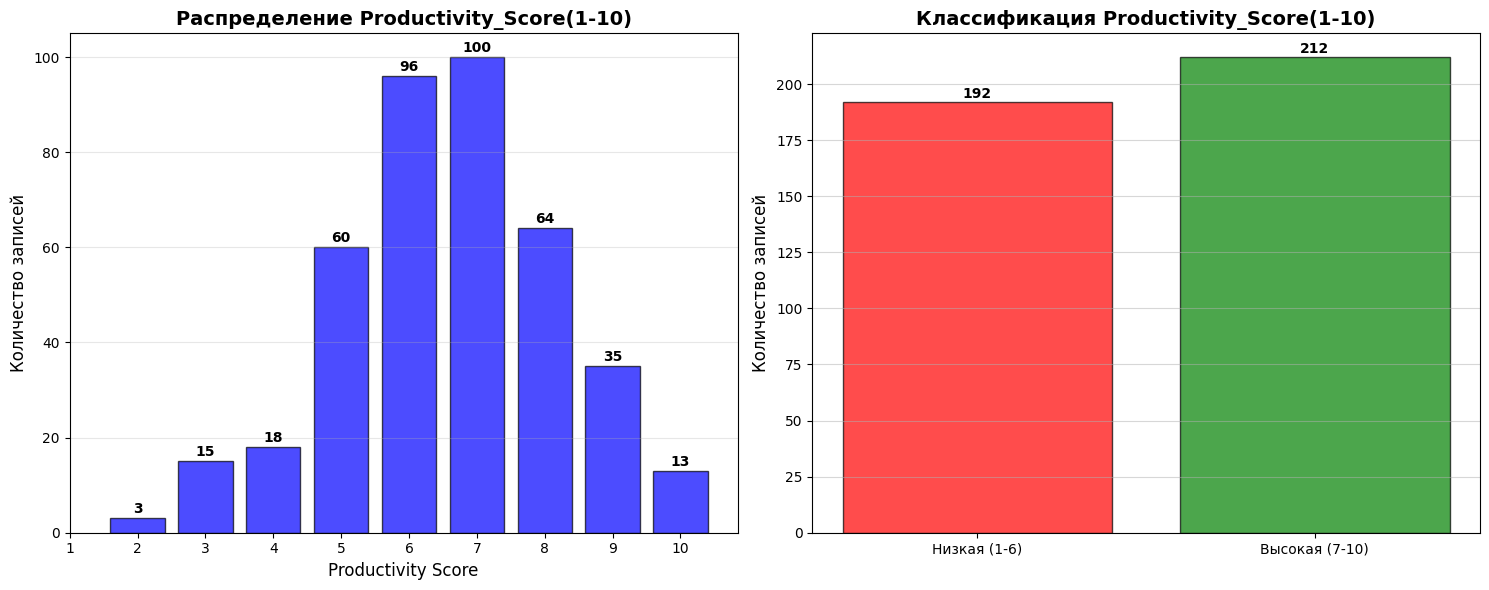

Productivity_Score(1-10)
2       3
3      15
4      18
5      60
6      96
7     100
8      64
9      35
10     13
Name: count, dtype: int64
Productivity_binary(0-1)
0    192
1    212
Name: count, dtype: int64


In [2]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

value_counts = df['Productivity_Score(1-10)'].value_counts().sort_index()

bars1 = ax1.bar(value_counts.index, value_counts.values, 
               color='blue', alpha=0.7, edgecolor='black')

ax1.set_title('Распределение Productivity_Score(1-10)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Productivity Score', fontsize=12)
ax1.set_ylabel('Количество записей', fontsize=12)
ax1.set_xticks(range(1, 11))
ax1.grid(True, alpha=0.3, axis='y')

for bar, count in zip(bars1, value_counts.values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{count}', ha='center', va='bottom', fontweight='bold')

df['Productivity_binary(0-1)'] = (df['Productivity_Score(1-10)'] >= 7).astype(int)
binary_counts = df['Productivity_binary(0-1)'].value_counts().sort_index()

binary_labels = ['Низкая (1-6)', 'Высокая (7-10)']
binary_values = [binary_counts[0], binary_counts[1]]

bars2 = ax2.bar(binary_labels, binary_values, 
               color=['red', 'green'], alpha=0.7, edgecolor='black')

ax2.set_title('Классификация Productivity_Score(1-10)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Количество записей', fontsize=12)
ax2.grid(True, alpha=0.5, axis='y')

for bar, count in zip(bars2, binary_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{count}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(value_counts)
print(binary_counts)

По графику видно, что данный класс является несбалансированным: наблюдаются два выраженных пика значений на уровнях "6" и "7". Тем не менее, при объединении значений в две группы распределение становится приблизительно равномерным.

## Оценка и сравнение результатов классификации.

In [3]:
df = df.drop(['User_ID'], axis=1)
le_gender = LabelEncoder()
df['Gender'] = le_gender.fit_transform(df['Gender'])
df = pd.get_dummies(df, columns=['Social_Media_Platform'], prefix='Platform')

X = df.drop(['Productivity_Score(1-10)', 'Productivity_binary(0-1)'], axis=1)
y = df['Productivity_binary(0-1)']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

### Метод kNN

In [4]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
y_proba_knn = knn.predict_proba(X_test)[:, 1]

print("Метод ближайших соседей:")
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

Метод ближайших соседей:
[[47 11]
 [14 50]]
              precision    recall  f1-score   support

           0       0.77      0.81      0.79        58
           1       0.82      0.78      0.80        64

    accuracy                           0.80       122
   macro avg       0.80      0.80      0.79       122
weighted avg       0.80      0.80      0.80       122



### Дерево решений

In [5]:
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)


print("Дерево решений:")
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

Дерево решений:
[[55  3]
 [ 1 63]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        58
           1       0.95      0.98      0.97        64

    accuracy                           0.97       122
   macro avg       0.97      0.97      0.97       122
weighted avg       0.97      0.97      0.97       122



## Сравнение результатов.

### Accuracy, Presicion, Recall, F-measure

In [6]:
y_proba_knn = knn.predict_proba(X_test)[:, 1]
y_proba_dt = dt.predict_proba(X_test)[:, 1]

metrics = {
    'Алгоритм': ['Метод ближайших соседей', 'Дерево решений'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_dt)
    ],
    'Precision': [
        precision_score(y_test, y_pred_knn),
        precision_score(y_test, y_pred_dt)
    ],
    'Recall': [
        recall_score(y_test, y_pred_knn),
        recall_score(y_test, y_pred_dt)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_knn),
        f1_score(y_test, y_pred_dt)
    ]
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df.round(3))

fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_proba_knn)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_proba_dt)

roc_knn = auc(fpr_knn, tpr_knn)
roc_dt = auc(fpr_dt, tpr_dt)

print(f"ROC метода ближайших соседей: {roc_knn:.3f}")
print(f"ROC дерево решений: {roc_dt:.3f}")

                  Алгоритм  Accuracy  Precision  Recall  F1-Score
0  Метод ближайших соседей     0.795      0.820   0.781     0.800
1           Дерево решений     0.967      0.955   0.984     0.969
ROC метода ближайших соседей: 0.897
ROC дерево решений: 0.967


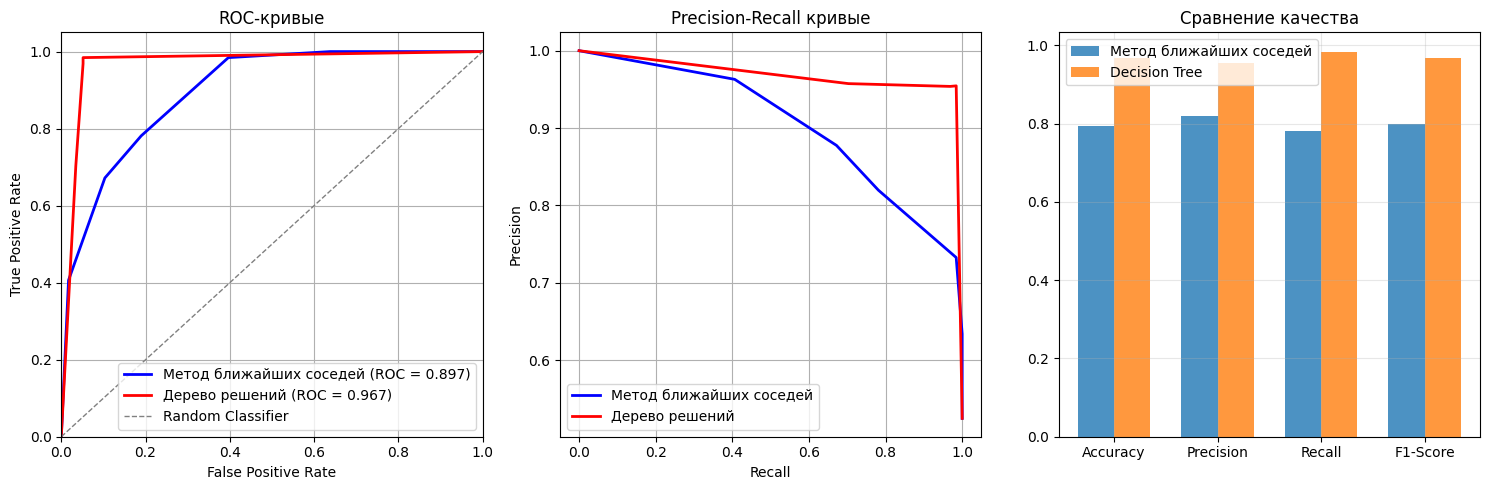

In [7]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, 
         label=f'Метод ближайших соседей (ROC = {roc_knn:.3f})')
plt.plot(fpr_dt, tpr_dt, color='red', lw=2, 
         label=f'Дерево решений (ROC = {roc_dt:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые')
plt.legend(loc="lower right")
plt.grid(True)

plt.subplot(1, 3, 2)
precision_knn, recall_knn, _ = precision_recall_curve(y_test, y_proba_knn)
precision_dt, recall_dt, _ = precision_recall_curve(y_test, y_proba_dt)

plt.plot(recall_knn, precision_knn, color='blue', lw=2, label='Метод ближайших соседей')
plt.plot(recall_dt, precision_dt, color='red', lw=2, label='Дерево решений')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривые')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
metrics_comparison = metrics_df.drop('Алгоритм', axis=1)
x_pos = np.arange(len(metrics_comparison.columns))
width = 0.35

plt.bar(x_pos - width/2, metrics_comparison.iloc[0], width, label='Метод ближайших соседей', alpha=0.8)
plt.bar(x_pos + width/2, metrics_comparison.iloc[1], width, label='Decision Tree', alpha=0.8)

plt.title('Сравнение качества')
plt.xticks(x_pos, metrics_comparison.columns)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Вывод


В рамках проведённого эксперимента алгоритм «Дерево решений» показал существенно более высокие показатели эффективности по сравнению с методом k-ближайших соседей (kNN). Ключевой причиной такого результата является высокая чувствительность kNN к эффекту «проклятия размерности», из-за которого при увеличении числа признаков качество работы алгоритма заметно снижается. Помимо этого, на эффективность kNN значительно влияют выбор числа соседей, используемая метрика расстояния и необходимость масштабирования данных. Несмотря на то что при грамотной настройке гиперпараметров и качественной предобработке данных производительность kNN может быть улучшена, в рамках данной задачи алгоритм «Дерево решений» оказался более предпочтительным благодаря устойчивости к высокой размерности признаков и лучшей интерпретируемости получаемой модели.